# Deep Learning for Computer Vision:  HW 5

## Computer Science: COMS W 4995 007

## Due: November 7, 2019

### Problem: Telling Cats from Dogs using VGG16

This assignment is based on the blog post
"Building powerful image classification models using very little data"
from blog.keras.io. Here you will build a classifier that can distinguish between pictures of dogs and cats. You will use a ConvNet (VGG16) that was pre-trained ImageNet. Your task will be to re-architect the network to solve your problem. To do this you will:
0. Make a training dataset, using images from the link below, with 10,000 images of cats and 10,000 images of dogs. Use 1,000 images of each category for your validation set. The data should be orgainized into folders named ./data/train/cats/ + ./data/train/dogs/ + ./data/validation/cats/ + ./data/validation/dogs/. (No need to worry about a test set for this assignment.)  
1. take VGG16 network architecture
2. load in the pre-trained weights from the link below for all layers except the last layers 
3. add a fully connected layer followed by a final sigmoid layer to replace the 1000 category softmax layer that was used when the network was trained on ImageNet
4. freeze all layers except the last two that you added
5. fine-tune the network on your cats vs. dogs image data
6. evaluate the accuracy
7. unfreeze all layers
8. continue fine-tuning the network on your cats vs. dogs image data
9. evaluate the accuracy
10. comment your code and make sure to include accuracy, a few sample mistakes, and anything else you would like to add

Downloads:
1. You can get your image data from:
https://www.kaggle.com/c/dogs-vs-cats/data. 
2. You can get your VGG16 pre-trained network weights by googling
"vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

(Note this assignment deviates from blog.keras.io in that it uses more data AND performs the fine-tuning in two steps: first freezing the lower layers and then un-freezing them for a final run of fine-tuning. The resulting ConvNet gets more than 97% accuracy in telling pictures of cats and dogs apart.)

A bunch of code and network definition has been included to to get you started. This is not meant to be a difficult assignment, as you have your final projects to work on!  Good luck and have fun!

Extra Credit: In addition to completing the above assignment, do this in Pytorch! You are on your own for figuring this out, but it should be fun and help get your ready for your final project. 

Here we import necessary libraries.

In [1]:
import os
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


We only have two classes.

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
nb_classes = 2
class_name = {
    0: 'cat',
    1: 'dog',
}

This let's us plot samples.

In [0]:
def show_sample(X, y, prediction=-1):
    im = X
    plt.imshow(im)
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
    else:
        plt.title("Class = %s" % (class_name[y]))

    plt.axis('on')
    plt.show()

Here we define where the data comes from and how much we have.

In [0]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = './imagenet_vgg16_fine-tuning/data/train'
validation_data_dir = './imagenet_vgg16_fine-tuning/data/validation'

nb_train_samples = 20000
nb_validation_samples = 2000
batch_size = 32
steps_per_epoch_train = nb_train_samples / batch_size
steps_per_epoch_val = nb_validation_samples / batch_size

In [7]:
# Unzip image data. NOTE: this is because the assignment was done through Google Colab
# where the data was first uploaded as a zip and then unzipped
!unzip /imagenet_vgg16_fine-tuning.zip

Archive:  /imagenet_vgg16_fine-tuning.zip
   creating: imagenet_vgg16_fine-tuning/
  inflating: imagenet_vgg16_fine-tuning/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5  
   creating: imagenet_vgg16_fine-tuning/data/
   creating: imagenet_vgg16_fine-tuning/data/train/
   creating: imagenet_vgg16_fine-tuning/data/train/cats/
  inflating: imagenet_vgg16_fine-tuning/data/train/cats/cat.100.jpg  
  inflating: imagenet_vgg16_fine-tuning/data/train/cats/cat.1000.jpg  
  inflating: imagenet_vgg16_fine-tuning/data/train/cats/cat.10062.jpg  
  inflating: imagenet_vgg16_fine-tuning/data/train/cats/cat.10063.jpg  
  inflating: imagenet_vgg16_fine-tuning/data/train/cats/cat.10074.jpg  
  inflating: imagenet_vgg16_fine-tuning/data/train/cats/cat.10086.jpg  
  inflating: imagenet_vgg16_fine-tuning/data/train/cats/cat.101.jpg  
  inflating: imagenet_vgg16_fine-tuning/data/train/cats/cat.10136.jpg  
  inflating: imagenet_vgg16_fine-tuning/data/train/cats/cat.10146.jpg  
  inflating: imagenet_vgg16

Keras training requires specifying how the data is going to be streamed
to to the "fitting" routine. Here the data is augmented with "new" examples which 
are sheared, zoomed, and flipped versions of the originals.

In [8]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Let's display some sample images from this dataset. Note that these are real images and this is not an easy problem. But also note that it is made simpler by the fact that the animals, for the most part, are relatively large and centered in the photos.

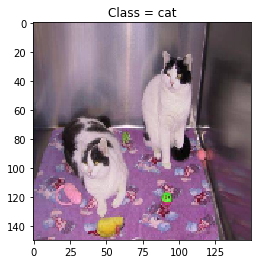

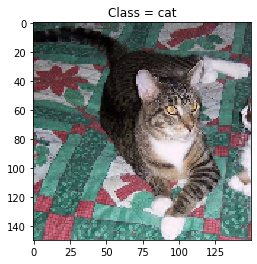

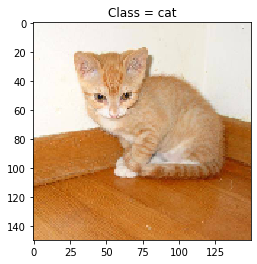

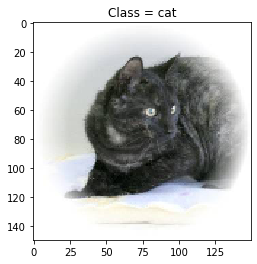

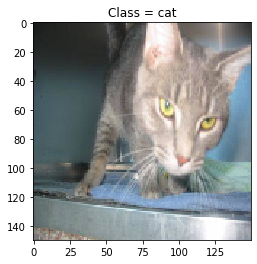

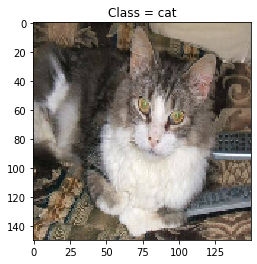

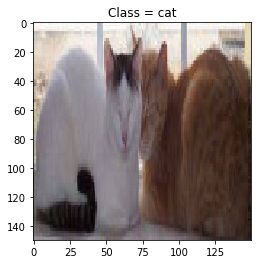

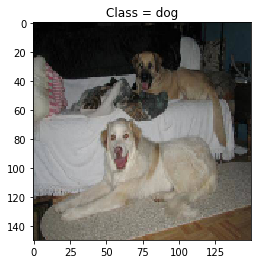

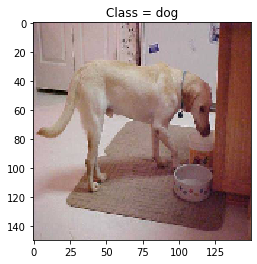

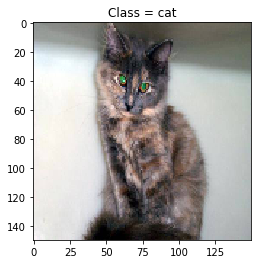

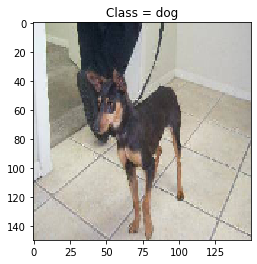

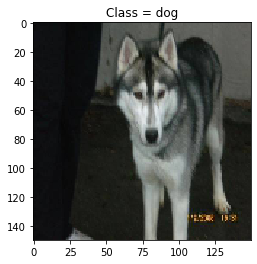

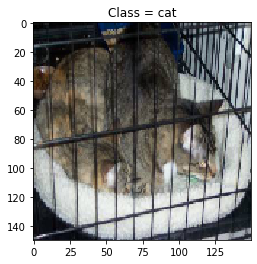

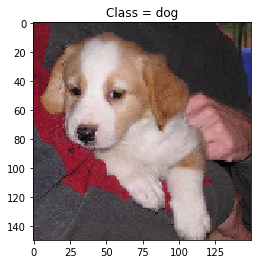

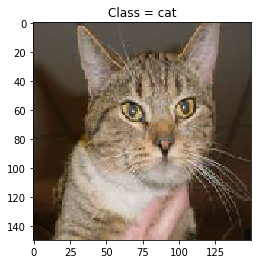

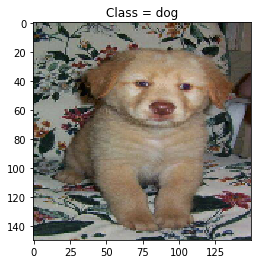

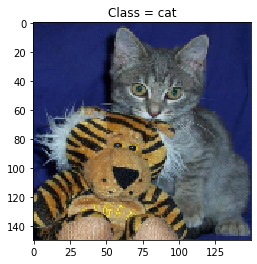

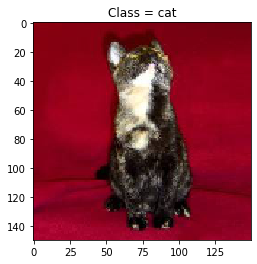

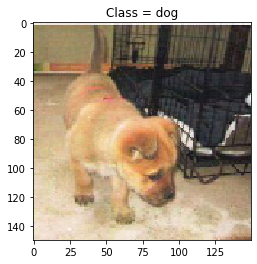

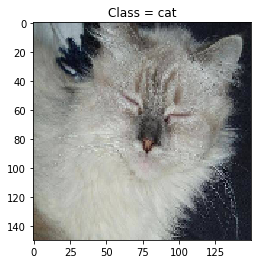

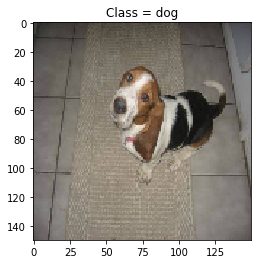

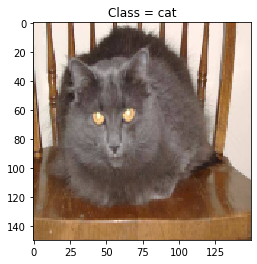

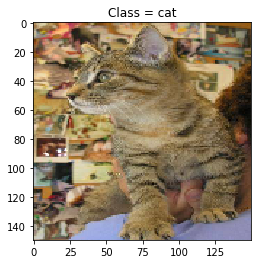

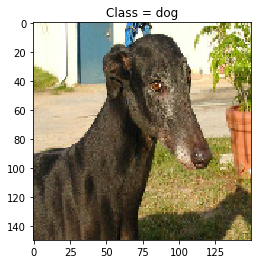

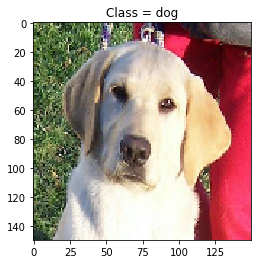

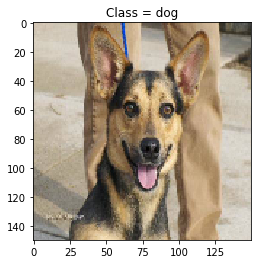

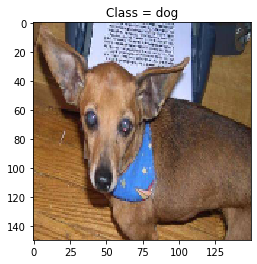

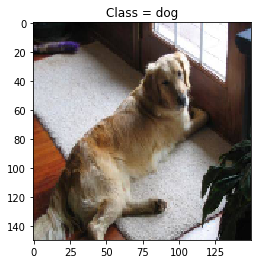

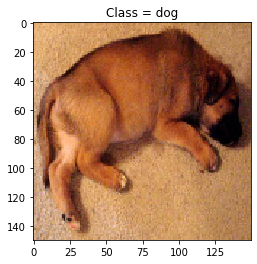

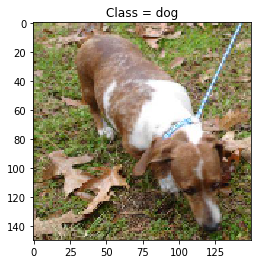

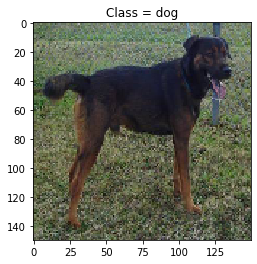

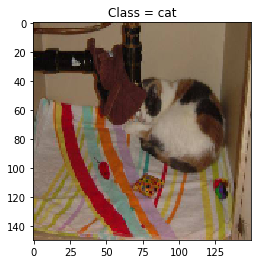

In [9]:
for X_batch, Y_batch in validation_generator:
    for i in range(len(Y_batch)):
        show_sample(X_batch[i, :, :, :], Y_batch[i])
    break

Here is our first model. It is a small ConvNet which does surprisingly well at the dog vs. cat problem. 
But we will be able to do much better later on. This network is not particularly deep, just three convolutional layers each with max pooling and a final fully connected layer.

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(63, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now we compile the network using cross entropy loss on our logistic sigmoid and print out network layers.

In [11]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])

print(model.summary())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
________________________

I was havinng permission troubles with creating dirs and writing files, so I jumped out to the shell to make these manually. These dirs will hold the training history, logging, and models created during training. 

In [12]:
%pushd
%mkdir -p history
%mkdir -p models
%mkdir -p logs
%cd logs 
%mkdir -p ./little_convnet
%mkdir -p ./vgg16_fine_tuning
%popd

/content/logs
/content
popd -> /content


Here we design the call backs that will record stuff while training. The first will create the log files that can be viewed using the command line tool Tensorboard. The second saves the "best model" so far, where best is based on the validation accuracy.

In [0]:
tensorboard_callback = TensorBoard(log_dir='./logs/little_convnet/', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models/little_convnet_weights.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

Now we are on to training the network. Note the use of the callbacks. Also note that the learning schedule was set back when we compiled the network.

In [16]:
nb_epoch = 10

hist_little_convet = model.fit_generator(train_generator, 
              initial_epoch=0, 
              verbose=1, 
              validation_data=validation_generator, 
              steps_per_epoch=steps_per_epoch_train, 
              epochs=nb_epoch, 
              callbacks=[tensorboard_callback, checkpoint_callback],
              validation_steps=steps_per_epoch_val)
                                                                                                                                   
pandas.DataFrame(hist_little_convet.history).to_csv("./history/little_convet.csv")

Epoch 1/10
625/625 [==============================] - 160s 257ms/step - loss: 0.5520 - acc: 0.7232 - val_loss: 0.4916 - val_acc: 0.7540
Epoch 2/10
625/625 [==============================] - 156s 250ms/step - loss: 0.5055 - acc: 0.7529 - val_loss: 0.4634 - val_acc: 0.7805
Epoch 3/10
625/625 [==============================] - 157s 252ms/step - loss: 0.4780 - acc: 0.7776 - val_loss: 0.4269 - val_acc: 0.8085
Epoch 4/10
625/625 [==============================] - 156s 250ms/step - loss: 0.4617 - acc: 0.7876 - val_loss: 0.4054 - val_acc: 0.8240
Epoch 5/10
625/625 [==============================] - 157s 251ms/step - loss: 0.4369 - acc: 0.8087 - val_loss: 0.3989 - val_acc: 0.8235
Epoch 6/10
625/625 [==============================] - 156s 250ms/step - loss: 0.4323 - acc: 0.8077 - val_loss: 0.4150 - val_acc: 0.8180
Epoch 7/10
625/625 [==============================] - 157s 251ms/step - loss: 0.4176 - acc: 0.8191 - val_loss: 0.4037 - val_acc: 0.8320
Epoch 8/10
625/625 [============================

In [17]:
accuracies = np.array([])
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
        break
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

Validation: accuracy = 0.871875  ;  loss = 0.349215


In [0]:
X_test, y_test = next(validation_generator)
predictions = model.predict_classes(X_test, batch_size=32, verbose=0)

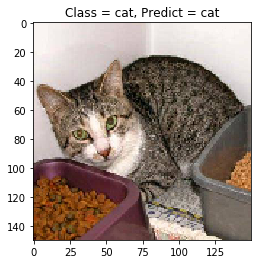

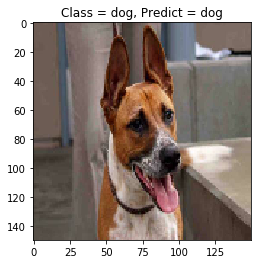

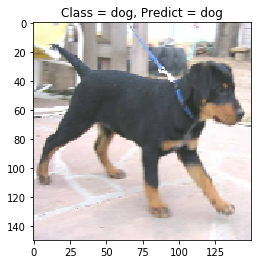

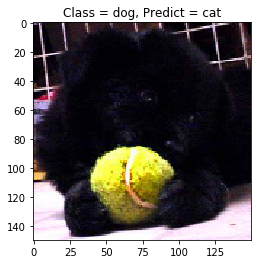

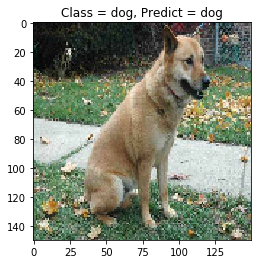

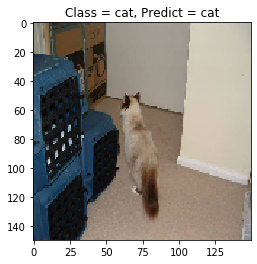

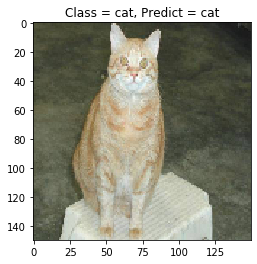

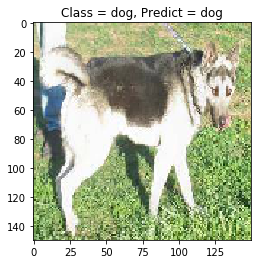

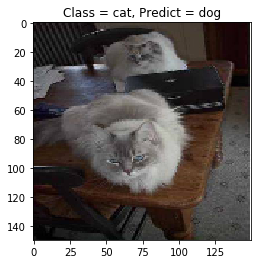

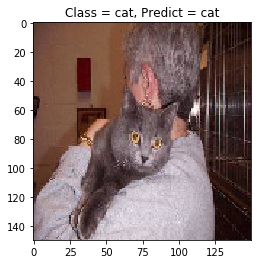

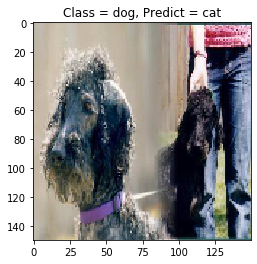

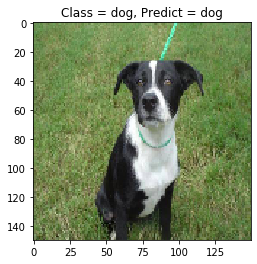

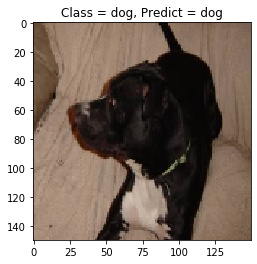

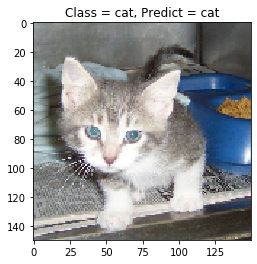

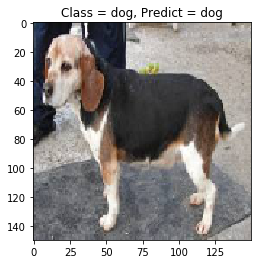

In [19]:
for i in range(15):
    show_sample(X_test[i, :, :, :], y_test[i], prediction=predictions[i, 0])

Now we move on to building a more powerful ConvNet: VGG16. We will not train it from scratch but rather load in the weights for the model from a pre-trained version, version that was trained on ImageNet. We will then chop of the last layer and replace it with one that fits our two class cat vs. dog problem. We will freeze the bottom layers of the network and only train the weights of the new last layer. Why? Because if we allow the whole model to train all the weights at once we might do damage to the carefully selected weights in the lower convolutional layers. So instead, we train only the top layer. This training produces a classifier that has 91% accuracy, which is quite an improvement over the last one. However, once this training converges, more or less, we then unfreeze the lower layers and let all the layers train. The final model gets 97% accuracy!

The routine below make a VGG16 network in either Theano or Tensorflow style. The only difference is the ordering of the volume indices. Note that it does not make the last layers as these would have to be removed.

#### PLEASE NOTE THAT YOUR NUMBERS WILL NOT BE EXACTLY THE SAME AS MINE. SO PLEASE DO NOT ASK ME IF YOUR NUMBERS "ARE GOOD ENOUGH."  THIS IS A GUIDELINE FOR WHAT IS POSSIBLE.

In [0]:
def build_vgg16(framework='tf'):

    if framework == 'th':
        # build the VGG16 network in Theano weight ordering mode
        # The commented line below was in the original code, it has been 
        # replaced with the line below in order to deal with errors
        # backend.set_image_dim_ordering('th')
        backend.common.set_image_dim_ordering('th')
    else:
        # build the VGG16 network in Tensorflow weight ordering mode
        # The commented line below was in the original code, it has been 
        # replaced with the line below in order to deal with errors
        # backend.set_image_dim_ordering('tf')
        backend.common.set_image_dim_ordering('tf')
        
    model = Sequential()
    if framework == 'th':
        model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    else:
        model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))
        
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model

In [0]:
# path to the model weights files.
weights_path = './imagenet_vgg16_fine-tuning/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
tf_model = build_vgg16('tf')
tf_model.load_weights(weights_path)

In [22]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
print(Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
print (tf_model.summary())
print(top_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 152, 152, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 150, 150, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 152, 152, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 77, 77, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 75, 75, 128)      

In [0]:
# add the model on top of the convolutional base
tf_model.add(top_model)

In [0]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in tf_model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
tf_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [26]:
# Train for 5 epochs with the layers frozen
nb_epoch = 5

tensorboard_callback = TensorBoard(log_dir='./logs/vgg/', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vggweights.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
vgg_hist= tf_model.fit_generator(train_generator, 
              initial_epoch=0, 
              verbose=1, 
              validation_data=validation_generator, 
              steps_per_epoch=steps_per_epoch_train, 
              epochs=nb_epoch, 
              callbacks=[tensorboard_callback, checkpoint_callback],
              validation_steps=steps_per_epoch_val)

pandas.DataFrame(vgg_hist.history).to_csv("./history/vgg.csv")

Epoch 1/5
625/625 [==============================] - 170s 272ms/step - loss: 0.2507 - acc: 0.8952 - val_loss: 0.1971 - val_acc: 0.9175
Epoch 2/5
625/625 [==============================] - 165s 264ms/step - loss: 0.2101 - acc: 0.9126 - val_loss: 0.1747 - val_acc: 0.9320
Epoch 3/5
625/625 [==============================] - 166s 265ms/step - loss: 0.1948 - acc: 0.9206 - val_loss: 0.1619 - val_acc: 0.9400
Epoch 4/5
625/625 [==============================] - 165s 264ms/step - loss: 0.1749 - acc: 0.9275 - val_loss: 0.1619 - val_acc: 0.9375
Epoch 5/5
625/625 [==============================] - 165s 264ms/step - loss: 0.1615 - acc: 0.9331 - val_loss: 0.1698 - val_acc: 0.9325


In [27]:
# Determine accuracy 
vgg_accuracies = np.array([])
vgg_losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    vgg_loss, vgg_accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    vgg_losses = np.append(vgg_losses, vgg_loss)
    vgg_accuracies = np.append(vgg_accuracies, vgg_accuracy)
    i += 1
    if i == 20:
        break
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(vgg_accuracies), np.mean(vgg_losses)))

Validation: accuracy = 0.943750  ;  loss = 0.132833


In [0]:
# Unfreeze network
for layer in tf_model.layers[:25]:
    layer.trainable = True

# Recompile network
tf_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [29]:
# Train network for 10 epochs after unfreezing layers
nb_epoch = 10

tensorboard_callback = TensorBoard(log_dir='./logs/vggunfreeze/', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vggweightsunfreeze.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
vgg_hist= tf_model.fit_generator(train_generator, 
              initial_epoch=0, 
              verbose=1, 
              validation_data=validation_generator, 
              steps_per_epoch=steps_per_epoch_train, 
              epochs=nb_epoch, 
              callbacks=[tensorboard_callback, checkpoint_callback],
              validation_steps=steps_per_epoch_val)

pandas.DataFrame(vgg_hist.history).to_csv("./history/vggunfreeze.csv")

Epoch 1/10
625/625 [==============================] - 185s 297ms/step - loss: 0.1350 - acc: 0.9468 - val_loss: 0.1138 - val_acc: 0.9520
Epoch 2/10
625/625 [==============================] - 181s 290ms/step - loss: 0.1010 - acc: 0.9610 - val_loss: 0.1360 - val_acc: 0.9380
Epoch 3/10
625/625 [==============================] - 181s 290ms/step - loss: 0.0850 - acc: 0.9667 - val_loss: 0.0953 - val_acc: 0.9635
Epoch 4/10
625/625 [==============================] - 183s 292ms/step - loss: 0.0766 - acc: 0.9706 - val_loss: 0.0866 - val_acc: 0.9625
Epoch 5/10
625/625 [==============================] - 182s 291ms/step - loss: 0.0661 - acc: 0.9745 - val_loss: 0.0783 - val_acc: 0.9695
Epoch 6/10
625/625 [==============================] - 181s 289ms/step - loss: 0.0588 - acc: 0.9783 - val_loss: 0.0775 - val_acc: 0.9720
Epoch 7/10
625/625 [==============================] - 181s 290ms/step - loss: 0.0539 - acc: 0.9798 - val_loss: 0.0726 - val_acc: 0.9720
Epoch 8/10
625/625 [============================

In [30]:
# Calculate accuracy on validation set
vgg_accuracies_unfrozen = np.array([])
vgg_losses_unfrozen = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    vgg_loss, vgg_accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    vgg_losses_unfrozen = np.append(vgg_losses_unfrozen, vgg_loss)
    vgg_accuracies_unfrozen = np.append(vgg_accuracies_unfrozen, vgg_accuracy)
    i += 1
    if i == 20:
        break
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(vgg_accuracies_unfrozen), np.mean(vgg_losses_unfrozen)))

Validation: accuracy = 0.976562  ;  loss = 0.076630


In [0]:
# Sample predictions using validation set
X_test_vgg, y_test_vgg = next(validation_generator)
vgg_predictions = tf_model.predict_classes(X_test_vgg, batch_size=32, verbose=0)

Sample Mistakes: 


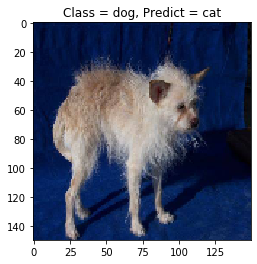

In [51]:
print('Sample Mistakes: ')
for i in range(32):
    if int(y_test_vgg[i]) != int(vgg_predictions[i, 0]):
        show_sample(X_test_vgg[i, :, :, :], y_test_vgg[i], prediction=vgg_predictions[i, 0])

Correct Predictions: 


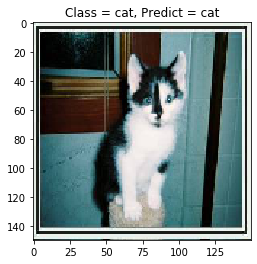

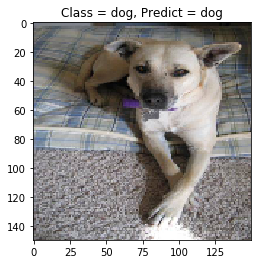

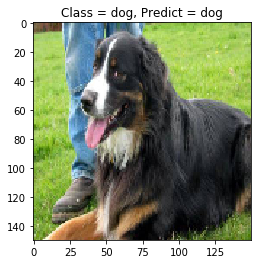

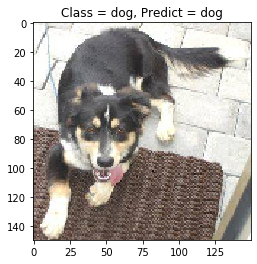

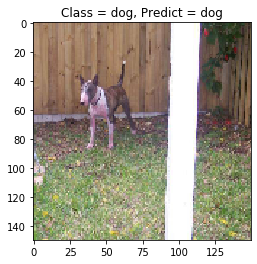

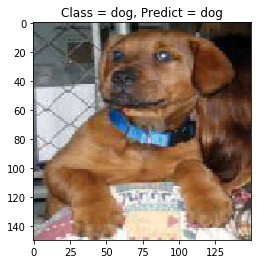

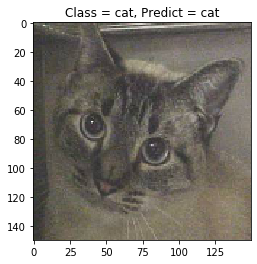

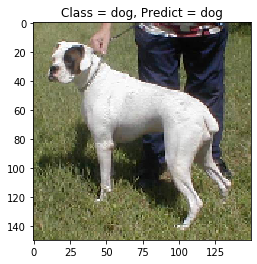

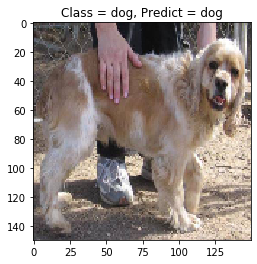

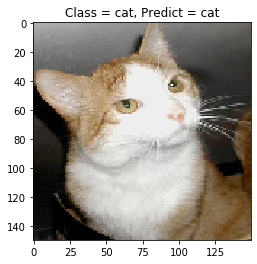

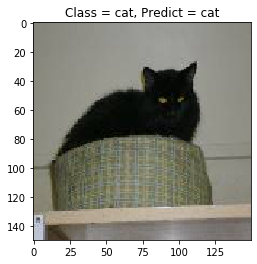

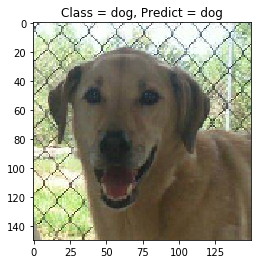

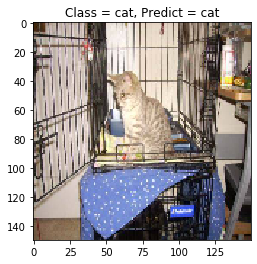

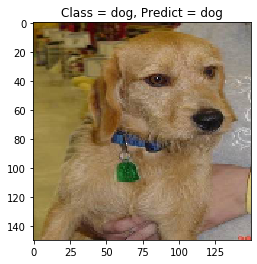

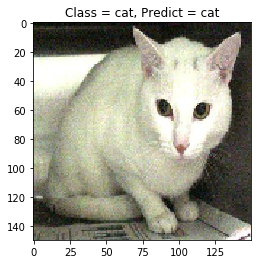

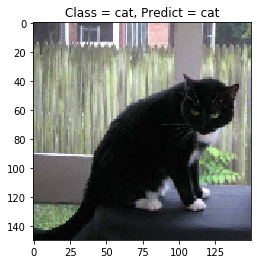

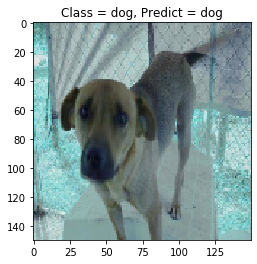

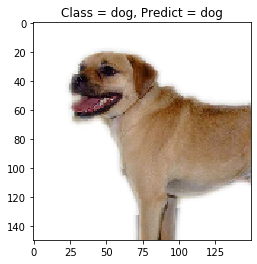

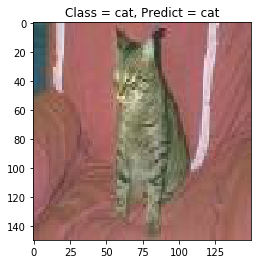

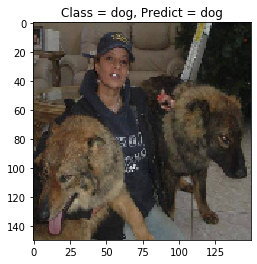

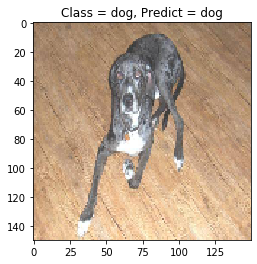

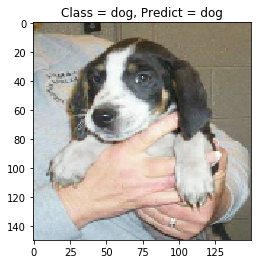

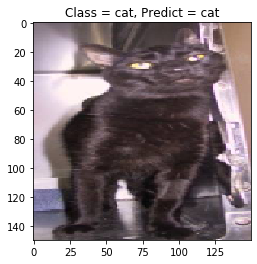

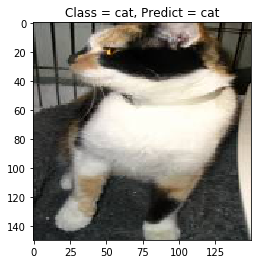

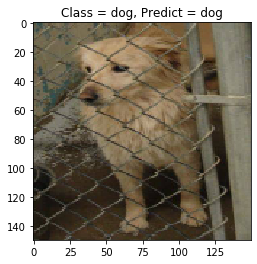

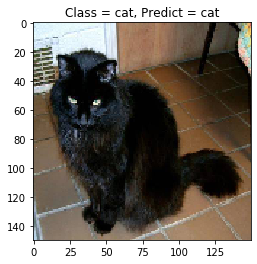

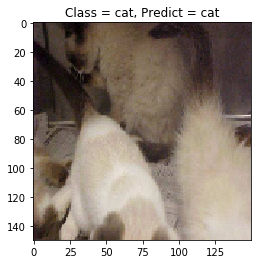

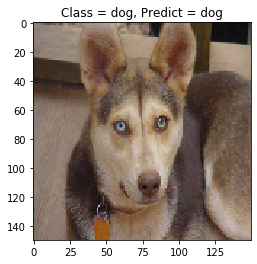

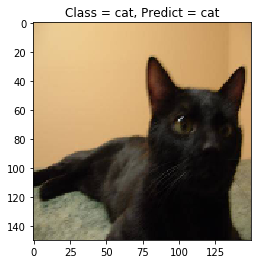

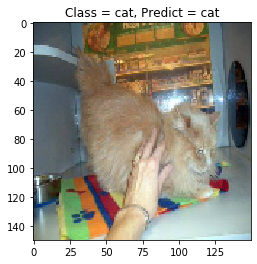

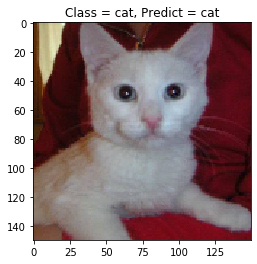

In [52]:
print('Correct Predictions: ')
for i in range(32):
      if int(y_test_vgg[i]) == int(vgg_predictions[i, 0]):
        show_sample(X_test_vgg[i, :, :, :], y_test_vgg[i], prediction=vgg_predictions[i, 0])